<a href="https://colab.research.google.com/github/undo76/colab-notebooks/blob/main/Softexp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import matplotlib
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from math import ceil
import math
from sklearn.metrics import accuracy_score

plt.style.use('bmh')
print(f'Cuda: {torch.cuda.is_available()}')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


Cuda: True


In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=0.5,
        std=0.2,
    ),
])
train = torchvision.datasets.FashionMNIST('fmnist/', download=True, transform = transform)
test = torchvision.datasets.FashionMNIST('fmnist/', train=False, download=True, transform=transform)

print(f'Data shape: {train.data.shape}')
print(f'Targets shape: {train.targets.shape}')
print(f'Target values: {train.targets.unique()}')
print(f'Target values: {train.classes}')



Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!
Data shape: torch.Size([60000, 28, 28])
Targets shape: torch.Size([60000])
Target values: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Target values: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


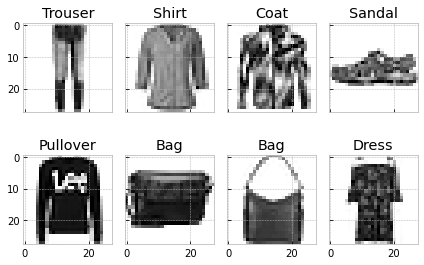

In [4]:
def show_image(idxs, dataset=train, ncols=4):  
  figure, axis = plt.subplots(ncols=min(ncols, len(idxs)), nrows=ceil(len(idxs)/ncols), sharex=True, sharey=True, squeeze=False)
  # figure.set_size_inches(10, 10)
  for i, idx in enumerate(idxs):
    axis[i//ncols, i%ncols].imshow(dataset.data[idx], cmap='gray_r')
    axis[i//ncols, i%ncols].set_title(dataset.classes[test.targets[idx]])
  plt.tight_layout()

show_image([3, 4, 17, 21, 1, 56, 34, 33], dataset=test)

In [5]:
class SoftExp(nn.Module):
    num_features: int
    alpha: Tensor

    def __init__(self, num_features, eps=1e-4):
      super().__init__()

      self.num_features = num_features
      self.eps=eps
      self.alpha = torch.nn.Parameter(torch.Tensor(self.num_features))
      self.reset_parameters()

    def reset_parameters(self):
      torch.nn.init.normal_(self.alpha, 0., 0.01)

    def forward(self, x):
      alpha = self.alpha
      m = 3
      x_m = (-1 + m - m * (alpha ** 2)) / (m * alpha + torch.sign(alpha) * self.eps)
      y_m = -torch.log(torch.clamp(1. - alpha * (x_m + alpha), min=self.eps)) / (alpha + torch.sign(alpha) * self.eps)
      lg = -torch.log(torch.clamp(1. - alpha * (x + alpha), min=self.eps)) / (alpha + torch.sign(alpha) * self.eps)

      ret = torch.where(self.alpha >= 0., 
                        (torch.exp(alpha * x) - 1) / (alpha + torch.sign(alpha) * self.eps) + alpha,
                        torch.where(x < x_m, 
                                    m * (x - x_m) + y_m, 
                                    lg
                                    )
                        )
      # print(self.alpha.abs().min().item(), self.alpha.max().item(), self.alpha.min().item(), x.max().item(), x.min().item(), ret.abs().max().item())
      return ret

In [10]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # self.softexp_1 = SoftExp(28 * 28)
        self.hidden_1 = nn.LazyLinear(128)
        # self.softexp_2 = SoftExp(128)
        self.bn1 = nn.BatchNorm1d(128)
        self.hidden_2 = nn.Linear(128, 64)
        # self.softexp_3 = SoftExp(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.output = nn.LazyLinear(10)

    def forward(self,x):
        # x = self.softexp_1(x)
        x = self.hidden_1(x)
        x = self.bn1(x)
        x = F.relu(x)
        # x = self.softexp_2(x)
        x = self.hidden_2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # x = self.softexp_3(x)
        y_pred = self.output(x)
        return y_pred

# Initialize the network
model = SimpleNetwork().to(device);

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
l1_penalty = torch.nn.L1Loss(size_average=False)

def train_model(model, dataset, optimizer, criterion, n_epochs=20):
  train, valid = torch.utils.data.random_split(dataset, [55000, 5000])
  trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
  for epoch in range(n_epochs):
    model.train()
    for batch, (images, labels) in enumerate(trainloader):
      optimizer.zero_grad()
      output = model(images.view(images.shape[0],-1).to(device))
      loss = criterion(output, labels.to(device))

      L1_reg = torch.tensor(0., requires_grad=True)
      for name, param in model.named_parameters():
        if 'alpha' in name:
          L1_reg = L1_reg + torch.norm(param, 1)
      loss = loss + 1e-4 * L1_reg

      # with torch.autograd.detect_anomaly():
      loss.backward() 
      #torch.nn.utils.clip_grad_norm_(model.parameters(), .1)
      optimizer.step()
    
    # Validate
    with torch.no_grad():
      model.eval()
      accuracy = []
      validloader = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)
      for batch, (images, labels) in enumerate(validloader):
        output = model(images.view(images.shape[0],-1).to(device))
        y_pred = torch.distributions.Categorical(logits=output).probs.argmax(1).detach().cpu().numpy()
        accuracy.append(accuracy_score(labels.numpy(), y_pred))

    print(f"Epoch {epoch} - Training: {loss:2f}\t Validation: {np.mean(accuracy):.2f}")
    
train_model(model, train, optimizer, criterion)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - Training: 0.403618	 Validation: 0.86
Epoch 1 - Training: 0.281906	 Validation: 0.87
Epoch 2 - Training: 0.256899	 Validation: 0.87
Epoch 3 - Training: 0.206570	 Validation: 0.88
Epoch 4 - Training: 0.246878	 Validation: 0.88
Epoch 5 - Training: 0.156130	 Validation: 0.89
Epoch 6 - Training: 0.209282	 Validation: 0.89
Epoch 7 - Training: 0.266554	 Validation: 0.89
Epoch 8 - Training: 0.212391	 Validation: 0.89
Epoch 9 - Training: 0.152552	 Validation: 0.89
Epoch 10 - Training: 0.185178	 Validation: 0.88
Epoch 11 - Training: 0.101808	 Validation: 0.89
Epoch 12 - Training: 0.193600	 Validation: 0.88
Epoch 13 - Training: 0.087579	 Validation: 0.89
Epoch 14 - Training: 0.188831	 Validation: 0.88
Epoch 15 - Training: 0.131601	 Validation: 0.89
Epoch 16 - Training: 0.191988	 Validation: 0.89
Epoch 17 - Training: 0.063594	 Validation: 0.89
Epoch 18 - Training: 0.152827	 Validation: 0.89
Epoch 19 - Training: 0.207481	 Validation: 0.88


In [11]:
# print(list(model.parameters()))
p1 = model.softexp_1.alpha.detach().cpu().numpy()
p2 = model.softexp_2.alpha.detach().cpu().numpy()
p3 = model.softexp_3.alpha.detach().cpu().numpy()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True)
fig.set_figwidth(10)
ax1.hist(p1, density=True)
ax2.hist(p2, density=True)
ax3.hist(p3, density=True)

plt.title("alpha")
plt.show()


AttributeError: ignored

In [12]:
with torch.no_grad():
  model.eval()
  accuracy = []
  testloader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=True)
  for batch, (images, labels) in enumerate(testloader):
    output = model(images.view(images.shape[0],-1).to(device))
    y_pred = torch.distributions.Categorical(logits=output).probs.argmax(1).detach().cpu().numpy()
    accuracy.append(accuracy_score(labels.numpy(), y_pred))

print(f"Accuracy (test) = {np.mean(accuracy):.2f} +/- {np.std(accuracy):.2f}")

Accuracy (test) = 0.89 +/- 0.02


In [447]:
def softexp(x, alpha, eps=1e-6):
  return np.where(alpha == 0, 
                  x,
                  np.where(alpha > 0, 
                          (np.exp(alpha * x) - 1) / (alpha + eps) + alpha,
                          - np.log(1 - alpha * (x + alpha)) / (alpha - eps)
                          )
                  )

def d_softexp(x, alpha):
  return np.where(alpha == 0, 1, 
                  np.where(alpha < 0, 1/(1 - alpha * (alpha + x)),
                          np.exp(alpha * x)))
  
def tangent_at(x0):
  """ y = m * (x - x0) + y0 """
  return lambda x, alpha: d_softexp(x0, alpha) * (x - x0) + softexp(x0, alpha)

def leaky_softexp(x, alpha, eps=1e-6):
    m = 10
    x_m = (-1 + m - m * alpha ** 2)/(m * alpha)
    y_m = softexp(x_m, alpha)
    return np.where(alpha == 0, x,
                    np.where(alpha > 0, 
                            (np.exp(alpha * x) - 1) / (alpha + eps) + alpha,
                            np.where(x > x_m,
                                     - np.log(1 - alpha * (x + alpha)) / (alpha - eps),
                                     m * (x - x_m) + y_m
                            )
                    )
            )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/i

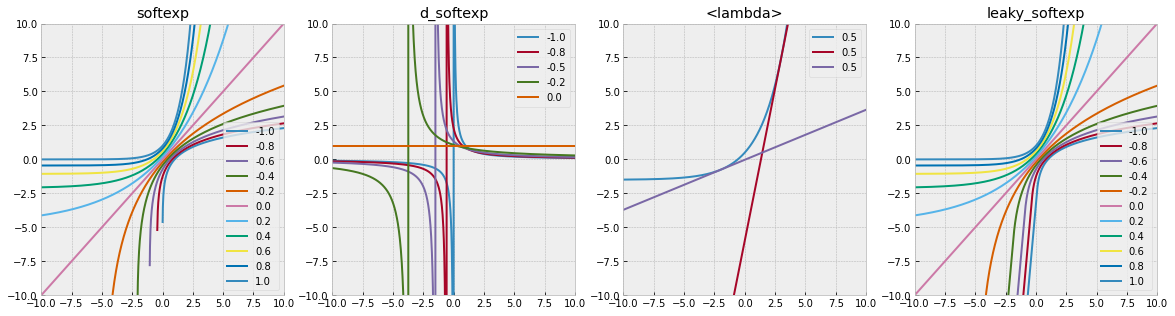

In [ ]:
def plot_function(f, alphas=np.linspace(-1., 1., 11), xs = np.linspace(-10, 10, 1000)):
  plt.figure(1, figsize=(5,5))
  for alpha in alphas:
    plt.plot(xs, f(xs, alpha=alpha), label=f'{alpha:.1f}')
  plt.title(f.__name__)
  plt.ylim(-10, 10)
  plt.xlim(-10,10)
  plt.legend()

with np.warnings.catch_warnings():
  np.warnings.filterwarnings('ignore', r'invalid value encountered in log')
  
  plt.figure(1, figsize=(20,5))
  plt.subplot(141)
  plot_function(softexp)

  plt.subplot(142)
  plot_function(d_softexp, alphas=np.linspace(-1, 0, 5))

  plt.subplot(143)
  plot_function(softexp, alphas=[0.5])
  plot_function(tangent_at(3), alphas=[0.5])
  plot_function(tangent_at(-2), alphas=[0.5])

  plt.subplot(144)
  plot_function(leaky_softexp)